In [2]:
%load_ext autoreload
%autoreload 2

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"

import math
import os
from typing import Any

import dill
import jax
import matplotlib
import matplotlib.pyplot as plt
import ml_collections
import numpy as np
from absl import logging
from matplotlib.collections import PolyCollection
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import art3d, axes3d

from deeprte.data import pipeline
from deeprte.model import model
from deeprte.model.utils import flat_params_to_haiku

logging.set_verbosity(logging.INFO)
import matplotlib.colors as colors
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import LightSource
from matplotlib.ticker import MultipleLocator

jax.local_devices()
# sns.set_theme()

ModuleNotFoundError: No module named 'deeprte'

In [154]:
def plot_phi(
    X,
    Y,
    Z,
    save_path=None,
    cmap="RdYlBu_r",
    norm=mcolors.PowerNorm(0.7),
    levels=25,
    figsize=(6, 6),
):
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={"projection": "3d"})

    ax.xaxis._axinfo["grid"].update({"linewidth": 0.3, "linestyle": "--", "color": "k"})
    ax.yaxis._axinfo["grid"].update({"linewidth": 0.3, "linestyle": "--", "color": "k"})
    ax.zaxis._axinfo["grid"].update({"linewidth": 0.3, "linestyle": "--", "color": "k"})

    # 设置网格背景色
    ax.xaxis.set_pane_color((0, 0, 0, 0))
    ax.yaxis.set_pane_color((0, 0, 0, 0))
    ax.zaxis.set_pane_color((0, 0, 0, 0))

    ax.zaxis._axinfo["juggled"] = (1, 2, 7)

    ax.xaxis._axinfo["tick"]["outward_factor"] = 0
    ax.xaxis._axinfo["tick"]["inward_factor"] = 0.4
    ax.yaxis._axinfo["tick"]["outward_factor"] = 0
    ax.yaxis._axinfo["tick"]["inward_factor"] = 0.4
    ax.zaxis._axinfo["tick"]["outward_factor"] = 0.4
    ax.zaxis._axinfo["tick"]["inward_factor"] = 0.0

    x0 = MultipleLocator(0.2)  # x轴每10一个刻度
    y0 = MultipleLocator(0.25)
    z0 = MultipleLocator(0.9)

    ax.xaxis.set_major_locator(x0)
    ax.yaxis.set_major_locator(y0)
    ax.zaxis.set_major_locator(z0)

    ax.tick_params(axis="z", labelsize=10, pad=-3, direction="in")
    ax.tick_params(axis="x", labelsize=10, pad=-5, direction="in")
    ax.tick_params(axis="y", labelsize=10, pad=-1, direction="in")
    font = {"size": 12, "weight": "normal"}
    ax.set_xlabel("x", labelpad=-10, rotation=-25, fontdict=font)
    ax.set_ylabel("y", labelpad=0, rotation=30, fontdict=font)
    ax.set_zlabel(r"Predict $f(r,\Omega)$", labelpad=-5, rotation=90, fontdict=font)

    # # Plot the 3D surface
    surf = ax.plot_surface(
        X, Y, Z, cmap=cmap, linewidth=0.2, alpha=0.7, lw=0.5, norm=norm
    )

    z_min, z_max = np.min(Z), np.max(Z)
    z_range = z_max - z_min
    offset = z_min - 0.2 * z_range
    ax.contour(
        X,
        Y,
        Z,
        zdir="z",
        offset=offset,
        cmap=cmap,
        norm=norm,
        levels=levels,
        linewidths=0.7,
    )

    cbar = fig.colorbar(
        surf,
        ax=ax,
        location="right",
        anchor=(-0.5, 0.4),
        shrink=0.6,
        format=matplotlib.ticker.ScalarFormatter(),
    )
    # cbar.minorticks_off()

    ax.set(zlim=(offset, z_max * 1.1))
    # ax.set_title(r"Predict $f(r,\Omega)$", fontsize=15, loc='center', pad=0)

    ax.view_init(elev=17, azim=280)
    # plt.show()
    if save_path is not None:
        plt.savefig(save_path)


def plot_contour(X, Y, predicted_phi, label_phi, save_path=None, figsize=(20, 5)):
    def _plt_contour(ax, X, Y, Z, cmap="RdBu_r", levels=25):
        ax.tick_params(axis="x", labelsize=15, pad=2, direction="in")
        ax.tick_params(axis="y", labelsize=15, pad=2, direction="in")
        font = {"size": 15, "weight": "normal"}
        ax.set_xlabel("x", labelpad=5, rotation=0, fontdict=font)
        ax.set_ylabel("y", labelpad=0, rotation=0, fontdict=font)

        cs = ax.contourf(X, Y, Z, cmap=cmap, levels=levels)

        return cs

    fig, axs = plt.subplots(1, 3, figsize=figsize)

    cs1 = _plt_contour(axs[0], X, Y, predicted_phi, cmap="RdYlBu_r")
    axs[0].set_title(r"Predict $f(r,\Omega)$", fontsize=17)
    cbar = fig.colorbar(cs1)
    cbar.ax.tick_params(labelsize=16)
    # axs[0].set_position([0.0, 0.23, 0.25, 0.45])

    cs2 = _plt_contour(axs[1], X, Y, label_phi, cmap="RdYlBu_r")
    axs[1].set_title(r"Exact $f(r,\Omega)$", fontsize=17)
    # cbar = fig.colorbar(cs2, ax=axs[1], location='right', anchor=(-1.1, 0.4), shrink=0.5, format=matplotlib.ticker.ScalarFormatter())
    cbar = fig.colorbar(cs2)
    cbar.ax.tick_params(labelsize=16)
    # axs[1].set_position([0.30, 0.23, 0.25, 0.45])

    cs3 = _plt_contour(axs[2], X, Y, abs(label_phi - predicted_phi), cmap="Reds")
    axs[2].set_title(r"Absolute Error", fontsize=17)
    # cbar = fig.colorbar(cs3, ax=axs[2], location='right', anchor=(1.2, 0.4), shrink=0.5, format=matplotlib.ticker.ScalarFormatter())
    cbar = fig.colorbar(cs3)
    cbar.ax.tick_params(labelsize=16)
    # axs[2].set_position([0.63, 0.23, 0.25, 0.45])

    # plt.show()

    if save_path is not None:
        plt.savefig(save_path)

In [165]:
RESULT_PATH = "/workspaces/deeprte/results/2023-06-13T20:54:42/example_0/result.dill"
FIRGUER_PATH = os.path.dirname(RESULT_PATH)

with open(RESULT_PATH, "rb") as f:
    result = dill.load(f)
print(
    jax.tree_util.tree_map(
        lambda x: x.shape if isinstance(x, np.ndarray) else x, result
    )
)
predicted_phi = result["predicted_phi"][0]
predicted_psi = result["predicted_psi"][0]
label_phi = result["phi_label"][0]

n = 40
h = 1 / n
X, Y = np.meshgrid(
    np.linspace(0 + 0.5 * h, 1 - 0.5 * h, 40), np.linspace(0 + 0.5 * h, 1 - 0.5 * h, 40)
)

{'phi_label': (1, 40, 40), 'predicted_phi': (1, 40, 40), 'predicted_psi': (1, 40, 40, 24), 'psi_label': (1, 40, 40, 24)}


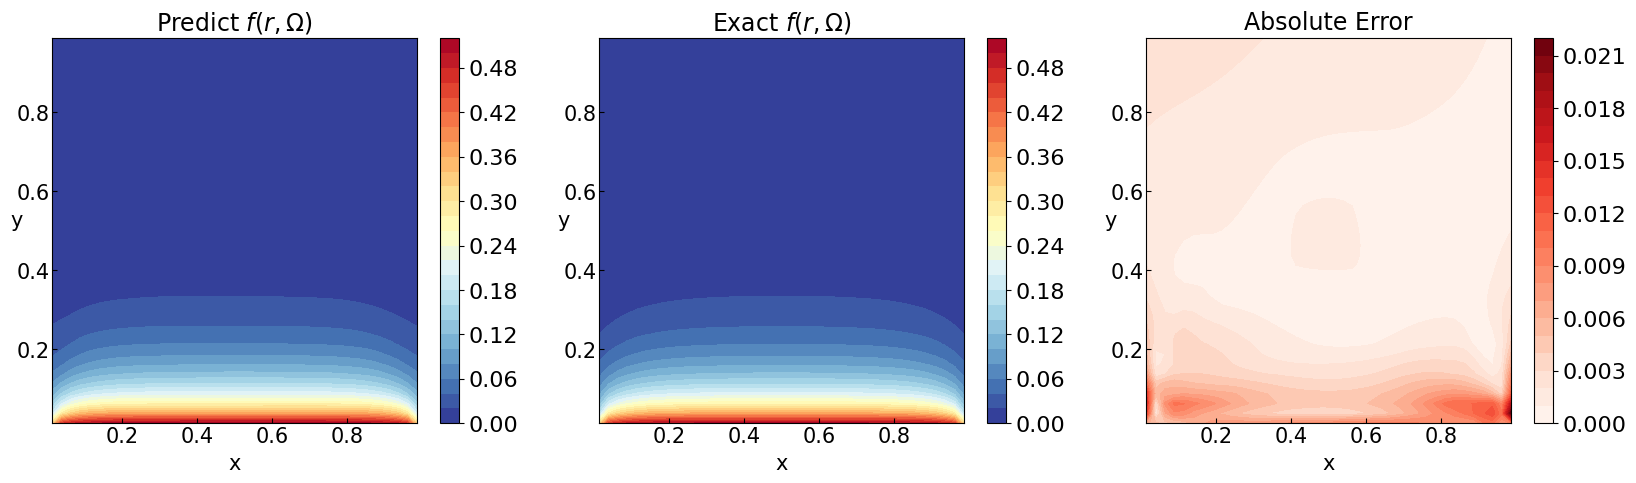

In [166]:
# plot_phi(X, Y, predicted_phi, save_path=os.path.join(FIRGUER_PATH, "phi.png"))
plot_contour(
    X, Y, predicted_phi, label_phi, save_path=os.path.join(FIRGUER_PATH, "contour.png")
)

In [1]:
import jax

In [6]:
import os

folder_path = "/nfs/my/projects/deeprte/results/2023-05-26T14:29:35"

for item in os.listdir(folder_path):
    item_path = os.path.join(folder_path, item)
    if os.path.isdir(item_path):
        # 处理文件夹
        print(item_path)
# list(os.walk(result_path))[2]

/nfs/my/projects/deeprte/results/2023-05-26T14:29:35/example_52
/nfs/my/projects/deeprte/results/2023-05-26T14:29:35/example_29
/nfs/my/projects/deeprte/results/2023-05-26T14:29:35/example_64
/nfs/my/projects/deeprte/results/2023-05-26T14:29:35/example_35
/nfs/my/projects/deeprte/results/2023-05-26T14:29:35/example_47
/nfs/my/projects/deeprte/results/2023-05-26T14:29:35/example_16
/nfs/my/projects/deeprte/results/2023-05-26T14:29:35/example_79
/nfs/my/projects/deeprte/results/2023-05-26T14:29:35/example_81
/nfs/my/projects/deeprte/results/2023-05-26T14:29:35/example_2
/nfs/my/projects/deeprte/results/2023-05-26T14:29:35/example_1
/nfs/my/projects/deeprte/results/2023-05-26T14:29:35/example_48
/nfs/my/projects/deeprte/results/2023-05-26T14:29:35/example_97
/nfs/my/projects/deeprte/results/2023-05-26T14:29:35/example_7
/nfs/my/projects/deeprte/results/2023-05-26T14:29:35/example_74
/nfs/my/projects/deeprte/results/2023-05-26T14:29:35/example_83
/nfs/my/projects/deeprte/results/2023-05-26

In [1]:
import deeprte

ModuleNotFoundError: No module named 'deeprte'